# 1. Overview
The goal of this competition is to better understand the relationship between different modalities in cells. The goal of this notebook is to gain a better understanding of the associated data. This equips us with the knowledge needed to make good decisions about model design and data layout.

**This is a work in progress. If any aspect needs clarification, please let me know. My understanding of genetics is very limited. Feel free to point out anything that is false.**

<div style="color:white;display:fill;
            background-color:#3bb2d6;font-size:200%;">
    <p style="padding: 4px;color:white;"><b>1.1 What do we want to learn?</b></p>
</div>

During transcription in cells, there is a known flow of information. DNA must be accessible to produce RNA. Produced RNA is used as a template to build proteins. Therefore, one could assume that we can use knowledge about the accessibility of DNA to predict future states of RNA and that we could use knowledge about RNA to predict the concentration of proteins in the future. In this challenge, we want to learn more about this relationship between DNA, RNA, and proteins. We thus need to capture information about three distinct properties of a cell:
* chromatin accessibility
* gene expression
* surface protein levels

<div style="color:white;display:fill;
            background-color:#3bb2d6;font-size:200%;">
    <p style="padding: 4px;color:white;"><b>1.2 How are those three properties of a cell presented?</b></p>
</div>

Before we have a look at how the information about those properties of a cell is laid out, we must note that the methods used to obtain the data do not capture all properties at once. We have two distinct methods for testing. The first one is the "10x Chromium Single Cell Multiome ATAC + Gene Expression" short "multiome" test. The second one is the "10x Genomics Single Cell Gene Expression with Feature Barcoding technology" short "citeseq" test.

With the multiome test, we can measure **chromatin accessibility and gene expression**. With the citeseq test, we can measure **gene expression and surface protein levels**.

Therefore, we will have data about chromatin accessibility and surface protein levels once (from multiome and citeseq, respectively). And we will have data about gene expression two times, one from each test. With that out of the way, let's dive into how the data is actually presented.

<div style="color:white;display:fill;
            background-color:#3bb2d6;font-size:200%;">
    <p style="padding: 4px;color:white;"><b>1.3 Imports</b></p>
</div>

In [1]:
# installs
!pip install --quiet tables

# imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# set paths
DATA_DIR = "../input/open-problems-multimodal/"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

FP_MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_multi_inputs.h5")
FP_MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_multi_targets.h5")
FP_MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR,"test_multi_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

# 2. Data

<div style="color:white;display:fill;
            background-color:#3bb2d6;font-size:200%;">
    <p style="padding: 4px;color:white;"><b>2.1 Chromatin accessibility data</b></p>
</div>

First we will have a look at the data about chromatin accessibility. Inspecting the corresponding HDF5 file, we see that the data is stored in one single table having dimensions (228942, 105942). Each value is stored as a 32bit float. Thus, to load the full table into memory while preserving the 32bit accuracy, we will need about 90 GB of RAM. This is quite a lot. Therefore, we will only look at a chunk of the data here and also don't load the whole dataset into memory while training or doing transformations. The other HDF5 tables also store values as 32bit floats.

In [2]:
# Loading the whole dataset into pandas exceeds the memory,
# therefore we define start and stop values
START = int(1e4)
STOP = START+1000

df_multi_train_x = pd.read_hdf(FP_MULTIOME_TRAIN_INPUTS,start=START,stop=STOP)
df_multi_train_x.head()

gene_id,GL000194.1:114519-115365,GL000194.1:55758-56597,GL000194.1:58217-58957,GL000194.1:59535-60431,GL000195.1:119766-120427,GL000195.1:120736-121603,GL000195.1:137437-138345,GL000195.1:15901-16653,GL000195.1:22357-23209,GL000195.1:23751-24619,...,chrY:7722278-7723128,chrY:7723971-7724880,chrY:7729854-7730772,chrY:7731785-7732664,chrY:7810142-7811040,chrY:7814107-7815018,chrY:7818751-7819626,chrY:7836768-7837671,chrY:7869454-7870371,chrY:7873814-7874709
cell_id,,,,,,,,,,,,,,,,,,,,,
ba6695d0c309,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30f05b8589b3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3feaf6105071,3.858121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dafc8ee5d1ed,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.005253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5e1e53b20abe,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As we can see, each individual cell is identified by a cell_id. We then have 228942 columns that are named something like "STUFF:NUMBER-NUMBER". STUFF is actually the name of a chromosome, while the numbers are a range indicating where the gene starts and ends. Let's have a look at what kind of chromosomes we have:

In [3]:
print(sorted(list({i[:i.find(':')] for i in df_multi_train_x.columns})))

['GL000194.1', 'GL000195.1', 'GL000205.2', 'GL000218.1', 'GL000219.1', 'KI270711.1', 'KI270713.1', 'KI270721.1', 'KI270726.1', 'KI270727.1', 'KI270728.1', 'KI270731.1', 'KI270734.1', 'chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chrX', 'chrY']


We actually find the chromosomes we expect, namely chr1-chr22, the 22 chromosomes humans have (called autosomes), and also chrX and chrY, being the gender-specific chromosomes. What about the ones starting with KI and GL? According to a quick internet search, those are unplaced genes. They most likely are part of the human genome, but we don't know yet on which chromosome they are. Noteworthy at this point is that the number of protein-coding genes in humans is estimated to be between 19.9k and 21.3k. Therefore, it looks like we have measurements of much more than just the protein-coding genes.

Next, we check the range of the values we have.

In [4]:
# first call to min/max gives us the min/max in each column. 
# Than we min/max again to get total min/max
print(f"Values range from {df_multi_train_x.min().min()} to {df_multi_train_x.max().max()}")

Values range from 0.0 to 16.933687210083008


So let's summarize what we have learned about the data corresponding to the accessibility of DNA so far:

* We have chromatin accessibility measurements for approximately 106k cells in total.
* We measure how accessible certain genes are in each cell, approximately 229k genes per cell.
* Accessibility is given in numbers from 0.0 to ~18. We do not know the upper bound because we have not looked at all the data yet.
* The values in our dataset use 32bit precision floats

What else do we want to know about chromatin accessibility data?

* How many values are non-zero for each cell?
* What is the standard deviation and what is the average non-zero value?

First, we will have a closer look at the chromatin accessibility values of each cell.

In [5]:
# get data about non-zero values
min_cells_non_zero = df_multi_train_x.gt(0).sum(axis=1).min()
max_cells_non_zero = df_multi_train_x.gt(0).sum(axis=1).max()
sum_non_zero_values = df_multi_train_x.sum().sum()
count_non_zero_values = df_multi_train_x.gt(0).sum().sum()
average_non_zero_per_gene = df_multi_train_x[df_multi_train_x.gt(0)].count(axis = 1).mean()

print(f"Each cell has at least {min_cells_non_zero} genes with non-zero accessibility values and a maximum of {max_cells_non_zero}.")
print(f"On average there are {round(average_non_zero_per_gene)} genes with non-zero accessibility values in each cell.")
print(f"The average non-zero value is about {sum_non_zero_values / count_non_zero_values:.2f}.")

# investigate standard deviation of features
std_dev_of_genes = df_multi_train_x.std()

# ignore genes that are only accessible in a single cell
std_dev_of_genes_without_singles = std_dev_of_genes[df_multi_train_x.gt(0).sum().gt(1)]
print(f"The standard deviation of our features is between {std_dev_of_genes_without_singles.min():.2f} and {std_dev_of_genes_without_singles.max():.2f}.\nThe average standard deviation is {std_dev_of_genes_without_singles.mean():.2f}")

Each cell has at least 767 genes with non-zero accessibility values and a maximum of 29927.
On average there are 6723 genes with non-zero accessibility values in each cell.
The average non-zero value is about 1.58.
The standard deviation of our features is between 0.03 and 0.71.
The average standard deviation is 0.33


That's already good information about what we can expect from our features for the first problem. To even better understand how many features we have for each sample, we will plot the number of cells per feature count.

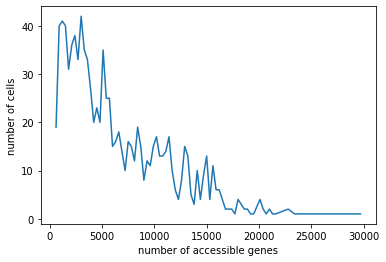

In [6]:
s = df_multi_train_x.gt(0).sum(axis = 1)
counts = s.groupby(lambda x: s[x] // 300).count()
counts.index = counts.index * 300

fig, ax = plt.subplots()
ax.plot(counts.index, counts.values)
ax.set_xlabel('number of accessible genes')
ax.set_ylabel('number of cells')
plt.show()

As we can see, the majority of our cells have between 2K and 7K accessible genes.

We now have quite a good understanding of the chromatin accessibility measured with the multiome test. We continue with investigating gene expression features.

<div style="color:white;display:fill;
            background-color:#3bb2d6;font-size:200%;">
    <p style="padding: 4px;color:white;"><b>2.2 Gene expression data</b></p>
</div>

As mentioned before we have two datasets containing gene expression data. We will first look at the data from the multiome test.

### 2.2.1 Gene expression from multiome
We would actually be able to load the whole dataset at once, but we will only look at the part corresponding to the already seen X values for now.

In [7]:
df_multi_train_y = pd.read_hdf(FP_MULTIOME_TRAIN_TARGETS, start=START, stop=STOP)
df_multi_train_y.head()

gene_id,ENSG00000121410,ENSG00000268895,ENSG00000175899,ENSG00000245105,ENSG00000166535,ENSG00000256661,ENSG00000184389,ENSG00000128274,ENSG00000094914,ENSG00000081760,...,ENSG00000086827,ENSG00000174442,ENSG00000122952,ENSG00000198205,ENSG00000198455,ENSG00000070476,ENSG00000203995,ENSG00000162378,ENSG00000159840,ENSG00000074755
cell_id,,,,,,,,,,,,,,,,,,,,,
ba6695d0c309,0.0,4.842627,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,4.842627,...,0.000000,0.000000,4.842627,0.0,4.842627,0.000000,0.0,0.000000,4.842627,0.000000
30f05b8589b3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,5.342478,0.0,0.000000,0.000000,0.000000
3feaf6105071,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,5.016188,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,5.016188,0.0,5.016188,0.000000,5.016188
dafc8ee5d1ed,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,4.752183,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,4.752183
5e1e53b20abe,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,4.115469,4.115469,...,4.115469,0.000000,4.115469,0.0,0.000000,5.203142,0.0,0.000000,4.115469,4.800423


As we can see, we have 23418 values that our model will need to predict. But what exactly are those values?

In [8]:
print(sorted(list({i[:10] for i in df_multi_train_y.columns})))
print(df_multi_train_y.columns.str.len().unique().item())

['ENSG000000', 'ENSG000001', 'ENSG000002']
15


As we can see, all of the features start with ENSG and then 5 zeroes. What we have here is called the Ensambl ID. The general form is ENS(species)(object type)(identifier).(version).
ENS tells us that we are looking at an ensembl ID. The species part is empty for human genes by convention. The object type is G for gene. It looks like the identifier is always 11 decimals long. And it looks like we don't have any version specifications in our data.

We will now check for similar properties than before.

In [9]:
print(f"Values for gene expression range from {df_multi_train_y.min().min():.2f} to {df_multi_train_y.max().max():.2f}")

# get data about non-zero values
min_cells_non_zero_y = df_multi_train_y.gt(0).sum(axis=1).min()
max_cells_non_zero_y = df_multi_train_y.gt(0).sum(axis=1).max()
sum_non_zero_values_y = df_multi_train_y.sum().sum()
count_non_zero_values_y = df_multi_train_y.gt(0).sum().sum()
average_non_zero_per_gene_y = df_multi_train_y[df_multi_train_y.gt(0)].count(axis = 1).mean()

print(f"Each cell has at least {min_cells_non_zero_y} genes with non-zero gene expression values and a maximum of {max_cells_non_zero_y}.")
print(f"On average there are {round(average_non_zero_per_gene_y)} genes with non-zero gene expression values in each cell.")
print(f"The average non-zero value for gene expression is about {sum_non_zero_values_y / count_non_zero_values_y:.2f}.")

# investigate standard deviation of features
std_dev_of_genes_y = df_multi_train_y.std()

# ignore genes that are only accessible in a single cell
std_dev_of_genes_without_singles_y = std_dev_of_genes_y[df_multi_train_y.gt(0).sum().gt(1)]
print(f"The standard deviation of gene expression values is between {std_dev_of_genes_without_singles_y.min():.2f} and {std_dev_of_genes_without_singles_y.max():.2f}.\nThe average standard deviation is {std_dev_of_genes_without_singles_y.mean():.2f}")

Values for gene expression range from 0.00 to 11.13
Each cell has at least 1804 genes with non-zero gene expression values and a maximum of 6207.
On average there are 3895 genes with non-zero gene expression values in each cell.
The average non-zero value for gene expression is about 5.08.
The standard deviation of gene expression values is between 0.18 and 3.29.
The average standard deviation is 1.35


We can see that the range of gene expression values is smaller than that for chromatin accessibility, but the standard deviation is higher. This might be important for the design of our model.

Even though this information will probably not influence the design of our model, let's still have a look at how many genes are expressed in cells. Just because it is interesting.

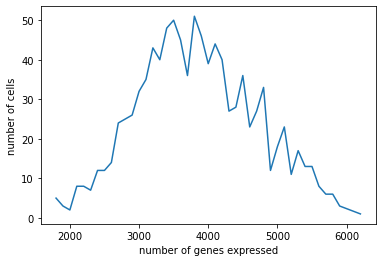

In [10]:
s = df_multi_train_y.gt(0).sum(axis = 1)
counts = s.groupby(lambda x: s[x] // 100).count()
counts.index = counts.index * 100

fig, ax = plt.subplots()
ax.plot(counts.index, counts.values)
ax.set_xlabel('number of genes expressed')
ax.set_ylabel('number of cells')
plt.show()

Having an overview of gene expression data obtained by the multiome test, we will now compare it to those obtained by the citeseq test.

### 2.2.2 Gene expression from citeseq

In [11]:
df_cite_train_x = pd.read_hdf(FP_CITE_TRAIN_INPUTS,start=START,stop=STOP)
df_cite_train_x.head()

gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
cell_id,,,,,,,,,,,,,,,,,,,,,
232a79b634ed,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,...,0.000000,3.925279,0.000000,0.0,0.0,0.0,3.925279,0.000000,0.000000,0.000000
c523fbe6d911,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,4.444875,0.000000,5.535631,0.000000
dd6dc8335202,0.0,0.0,0.0,4.154367,0.0,0.00000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,4.154367,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
54f4a4831971,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,3.569181,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,3.569181,4.248138,0.000000
64d88ab761a1,0.0,0.0,0.0,0.000000,0.0,4.49919,0.0,3.817099,0.0,0.0,...,4.900942,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,3.817099


The first thing we notice is that the start of our gene_id looks much like what we have seen in the multiome data, but there is a new suffix. So what is it about the suffix?

Checking the Ensembl ID of gene_id on [ensembl.org](https://www.ensembl.org/Homo_sapiens/Gene/Summary?db=core;g=ENSG00000121410;r=19:58345178-58353492) (in this case for ENSG00000121410) we see that the suffix is actually the name of the gene. As we will see in the next code cell, the gene_id is unique even without this suffix, so it looks like redundant information for now.

In [12]:
gene_ids_multiome = set(df_multi_train_y.columns)
print(f"Different Gene IDs in multiome: {len(gene_ids_multiome)}")
#for now we just keep the stem of the gene_id
gene_ids_citeseq = set([i[:i.find("_")] for i in df_cite_train_x.columns])
print(f"Different Gene IDs in citeseq: {len(gene_ids_citeseq)}")

Different Gene IDs in multiome: 23418
Different Gene IDs in citeseq: 22050


As mentioned, stripping of the suffix still produces unique names.

Let's check for overlap in both datasets about gene expression.

In [13]:
print(f"Elements in Set Union: {len(gene_ids_citeseq | gene_ids_multiome)}")
print(f"Elements in Set Intersection: {len(gene_ids_citeseq & gene_ids_multiome)}")
print(f"multiome has {len(gene_ids_multiome - gene_ids_citeseq)} unique gene ids.")
print(f"Citeseq has {len(gene_ids_citeseq - gene_ids_multiome)} unique gene ids.")

Elements in Set Union: 27082
Elements in Set Intersection: 18386
multiome has 5032 unique gene ids.
Citeseq has 3664 unique gene ids.


Even though we have a huge intersection, there are quite a few genes unique to each test.

We will now again get information about distribution of values:

In [14]:
print(f"Values for gene expression range from {df_cite_train_x.min().min():.2f} to {df_cite_train_x.max().max():.2f}")

# get data about non-zero values
min_cells_non_zero_y = df_cite_train_x.gt(0).sum(axis=1).min()
max_cells_non_zero_y = df_cite_train_x.gt(0).sum(axis=1).max()
sum_non_zero_values_y = df_cite_train_x.sum().sum()
count_non_zero_values_y = df_cite_train_x.gt(0).sum().sum()
average_non_zero_per_gene_y = df_cite_train_x[df_cite_train_x.gt(0)].count(axis = 1).mean()

print(f"Each cell has at least {min_cells_non_zero_y} genes with non-zero gene expression values and a maximum of {max_cells_non_zero_y}.")
print(f"On average there are {round(average_non_zero_per_gene_y)} genes with non-zero gene expression values in each cell.")
print(f"The average non-zero value for gene expression is about {sum_non_zero_values_y / count_non_zero_values_y:.2f}.")

# investigate standard deviation of features
std_dev_of_genes_y = df_cite_train_x.std()

# ignore genes that are only accessible in a single cell
std_dev_of_genes_without_singles_y = std_dev_of_genes_y[df_cite_train_x.gt(0).sum().gt(1)]
print(f"The standard deviation of gene expression values is between {std_dev_of_genes_without_singles_y.min():.2f} and {std_dev_of_genes_without_singles_y.max():.2f}.\nThe average standard deviation is {std_dev_of_genes_without_singles_y.mean():.2f}")

Values for gene expression range from 0.00 to 11.29
Each cell has at least 2234 genes with non-zero gene expression values and a maximum of 7319.
On average there are 5003 genes with non-zero gene expression values in each cell.
The average non-zero value for gene expression is about 4.39.
The standard deviation of gene expression values is between 0.14 and 2.88.
The average standard deviation is 1.12


We can see that the gene expression features obtained by the citeseq and the multiome test are quite similar. Values are in the same range and also the standard deviation and average non-zero values are of comparable size. For now, we only had a look at part of the data, so it will be interesting to see if this holds for all the data. We will get to that later.

For now, let's have a look at how many genes are expressed in individual cells.

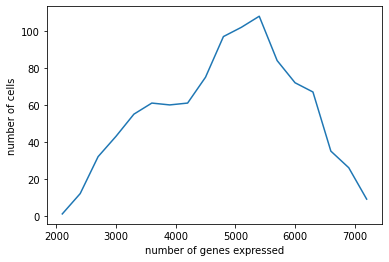

In [15]:
s = df_cite_train_x.gt(0).sum(axis = 1)
counts = s.groupby(lambda x: s[x] // 300).count()
counts.index = counts.index * 300

fig, ax = plt.subplots()
ax.plot(counts.index, counts.values)
ax.set_xlabel('number of genes expressed')
ax.set_ylabel('number of cells')
plt.show()

This sums up our investigation of the gene expression data obtained by the citeseq test. We saw that the data is comparable to that obtained by multiome. One key difference is that both have unique genes that are only measured in one test. Later, we will also investigate if the comparability of the data is due to preceding normalization of the raw data obtained by the tests and also address the question of what an expression value of e. g. 2.4 actually means.

<div style="color:white;display:fill;
            background-color:#3bb2d6;font-size:200%;">
    <p style="padding: 4px;color:white;"><b>2.3 Surface protein level data</b></p>
</div>

Lastly, we will have a look at the surface protein levels data gathered by citeseq.

In [16]:
df_cite_train_y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
df_cite_train_y.head()

gene_id,CD86,CD274,CD270,CD155,CD112,CD47,CD48,CD40,CD154,CD52,...,CD94,CD162,CD85j,CD23,CD328,HLA-E,CD82,CD101,CD88,CD224
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,1.167804,0.622530,0.106959,0.324989,3.331674,6.426002,1.480766,-0.728392,-0.468851,-0.073285,...,-0.448390,3.220174,-0.533004,0.674956,-0.006187,0.682148,1.398105,0.414292,1.780314,0.548070
d02759a80ba2,0.818970,0.506009,1.078682,6.848758,3.524885,5.279456,4.930438,2.069372,0.333652,-0.468088,...,0.323613,8.407108,0.131301,0.047607,-0.243628,0.547864,1.832587,0.982308,2.736507,2.184063
c016c6b0efa5,-0.356703,-0.422261,-0.824493,1.137495,0.518924,7.221962,-0.375034,1.738071,0.142919,-0.971460,...,1.348692,4.888579,-0.279483,-0.131097,-0.177604,-0.689188,9.013709,-1.182975,3.958148,2.868600
ba7f733a4f75,-1.201507,0.149115,2.022468,6.021595,7.258670,2.792436,21.708519,-0.137913,1.649969,-0.754680,...,1.504426,12.391979,0.511394,0.587863,-0.752638,1.714851,3.893782,1.799661,1.537249,4.407671
fbcf2443ffb2,-0.100404,0.697461,0.625836,-0.298404,1.369898,3.254521,-1.659380,0.643531,0.902710,1.291877,...,0.777023,6.496499,0.279898,-0.841950,-0.869419,0.675092,5.259685,-0.835379,9.631781,1.765445


Compared to what we have seen so far, the number of columns in this data set is quite small. We have measurements of 140 features per cell. Most of the names start with CD, which is short for "Cluster of differentiation". CDs are used to classify surface molecules a cell expresses. This information can then be used to get an idea of what kind of cell is present, or what function this cell is supposed to serve in the body (I am not sure if my understanding here is even remotely accurate).

Let's forget about the biological view for a moment and focus on the data science centric view. As we will see in the next cell, we have no zero values in this dataset, and thus much of the computation we did before (counting non-zero values, for example) is pointless. We will look at other features:

In [17]:
print(f"Measurements of surface protein levels range from {df_cite_train_y.min().min():.2f} to {df_cite_train_y.max().max():.2f}.")
print(f"The average value is {df_cite_train_y.mean().mean():.2f}.")
print(f"The standard deviation of surface protein levels is between {df_cite_train_y.std().min():.2f} and {df_cite_train_y.std().max():.2f}.")
print(f"The average standard deviation is {df_cite_train_y.std().mean():.2f}.")

Measurements of surface protein levels range from -52.48 to 120.46.
The average value is 1.89.
The standard deviation of surface protein levels is between 0.73 and 7.87.
The average standard deviation is 1.76.


We would also like to know if the absence of zero values could be due to inaccuracy in measurements. The following code checks for that. ATTENTION: As of right now, the threshold is completely arbitrary and will be revised when I know how accurate the test is!

In [18]:
threshold = 0.1
df_cite_train_y.applymap(lambda x: abs(x)).gt(threshold).sum(axis = 1)
print(f"Each cell has between {df_cite_train_y.applymap(lambda x: abs(x)).gt(threshold).sum(axis = 1).min()} and {df_cite_train_y.applymap(lambda x: abs(x)).gt(threshold).sum(axis = 1).max()} measurements with absolute values over {threshold}.")

Each cell has between 103 and 140 measurements with absolute values over 0.1.


It does not look like inaccuracy in measurements is the reason for the absence of 0 values, but as said, this needs to be checked!

# 3 Other Data
On top of the data we already saw, there is also a file containing metadata and two files needed to make a submission for the competition. We will first have a look at the metadata and then at the competition-related data.

<div style="color:white;display:fill;
            background-color:#3bb2d6;font-size:200%;">
    <p style="padding: 4px;color:white;"><b>3.1 Inspection of metadata.csv</b></p>
</div>

The Metadata is stored in the file metadata.csv. The file contains one row for each cell in the dataset and provides some additional information about that cell.

In [19]:
df_meta = pd.read_csv(FP_CELL_METADATA).set_index("cell_id")
df_meta

,day,donor,cell_type,technology
cell_id,,,,
c2150f55becb,2,27678,HSC,citeseq
65b7edf8a4da,2,27678,HSC,citeseq
c1b26cb1057b,2,27678,EryP,citeseq
917168fa6f83,2,27678,NeuP,citeseq
2b29feeca86d,2,27678,EryP,citeseq
...,...,...,...,...
96a60b026659,10,31800,hidden,multiome
d493e546991e,10,31800,hidden,multiome
05666c99aa48,10,31800,hidden,multiome


For each cell, we see the **day** column tells us on which day the test was performed. The test that was actually performed is shown in the **technology** column. Note that experiments started on day 1, therefore the first tests were performed one day after the cells were injected with Neupogen for the first time ([compare here](https://allcells.com/research-grade-tissue-products/mobilized-leukopak/)). For each of the four donors, we have a **donor** ID giving us information about the origin of the cell. Lastly, there is a **cell_type** column. The cell types are labels assigned by humans. They might be imprecise and this information is not available for test data since it would be possible to draw conclusions about surface protein levels, for example. It is not clear if we can make use of that later (maybe we can use it for creating balanced splits, but we will see).

[jirkaborovec](https://www.kaggle.com/jirkaborovec) already composed a great analysis of the metadata in this [notebook](https://www.kaggle.com/code/jirkaborovec/mmscel-inst-eda-stat-predictions). I will copy some parts here for readability and add some comments myself.

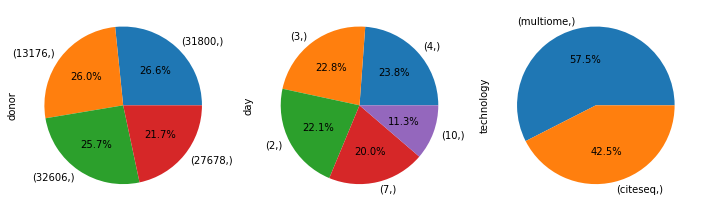

In [20]:
fig, axarr = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
for i, col in enumerate(["donor", "day", "technology"]):
    _= df_meta[[col]].value_counts().plot.pie(ax=axarr[i], autopct='%1.1f%%', ylabel=col)

As we can see, the cell data is pretty balanced. We have almost an equal number of cells from each donor (the big numbers in the first picture are the donor ids). Also, the days of the experiment were fairly balanced. The last day, day 10, only receives an 11% share of the cells. Day 10 is also the only day not present in the train data at all! Also, the train set does not contain any data from donor 27678!

We have slightly more data available for the multinome test. It is not the worst since our model also has to predict many more features for that test.

The distribution of data in general is pretty well balanced (e. g., the number of tests taken / test / day is well distributed). For a more in-depth analysis of the metadata, I highly recommend the already mentioned [notebook](https://www.kaggle.com/code/jirkaborovec/mmscel-inst-eda-stat-predictions).

<div style="color:white;display:fill;
            background-color:#3bb2d6;font-size:200%;">
    <p style="padding: 4px;color:white;"><b>3.2 Inspection of submission helpers</b></p>
</div>

There are two files related to result submission. evaluation_ids.csv specifies the data that needs to be submitted to the competition, and sample_submission.csv is meant as a guide for formatting the submitted data.

# X Notes

There are still some open questions in the text we need to address. Also, we want to get an understanding of the accuracy of the values and thus how many bits we will take for storage of data in the final data format.